# Приоритизация гипотез для увеличения выручки интернет магазина. Анализ A/B-теста.

Описание данных:

- Данные для первой части:

-  Файл /datasets/hypothesis.csv
 -  Hypothesis — краткое описание гипотезы;
 -  Reach — охват пользователей по 10-балльной шкале;
 -  Impact — влияние на пользователей по 10-балльной шкале;
 -  Confidence — уверенность в гипотезе по 10-балльной шкале;
 -  Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

- Данные для второй части:

-  Файл /datasets/orders.csv
  -  transactionId — идентификатор заказа;
  -  visitorId — идентификатор пользователя, совершившего заказ;
  -  date — дата, когда был совершён заказ;
  -  revenue — выручка заказа;
  -  group — группа A/B-теста, в которую попал заказ.
  
- Файл /datasets/visitors.csv
 
  -  date — дата;
  -  group — группа A/B-теста;
  -  visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.stats as st


In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 200)

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')


In [4]:
display(hypothesis.head())
display(orders.head())
display(visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [5]:
print('hypothesis')
display(hypothesis.info())
print('orders')
display(orders.info())
print('visitors')
display(visitors.info())

hypothesis
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

visitors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [6]:
# def df_overview(df):
#     df.info()
#     print('\nСлучайная выборка по данным\n')
#     display(df.sample(n=5, random_state=1))
#     print('\nПервичная статистика по данным\n')
#     display(df.describe().T)
#     print('\nКоличество полных дубликатов:',sum(df.duplicated()))
# df_overview(orders)

Изучив данные, видим, что необходимо изменить тип данных в столбцах  с датами и заменить стиль написания названий столбцов на snake case 

## Предобработка данных

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns = {'transactionId':'transaction_id','visitorId':'visitor_id'})
#display(hypothesis.head())
#display(orders.head())

In [8]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
display(orders.info(), visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

None

In [9]:
# Находим пользователей присутствующих как в группе А, так и в группе В. 
orders_a = orders[orders['group'] == 'A']
orders_b = orders[orders['group'] == 'B']
x = orders_b['visitor_id']
double = orders_a.query('visitor_id in @x')
double = double['visitor_id']

print('Количество пользователей, находящихся одновременно в группе А и В:', double.nunique())
display(orders.query('visitor_id in @double').sort_values(by = 'visitor_id').head())

Количество пользователей, находящихся одновременно в группе А и В: 58


,transaction_id,visitor_id,date,revenue,group
703,4293855558,8300375,2019-08-07,1790,A
71,3679129301,8300375,2019-08-01,10510,B
823,2971973105,199603092,2019-08-27,2790,A
246,437656952,199603092,2019-08-02,3488,B
26,2223239646,199603092,2019-08-15,3488,A


In [10]:
#Убираем пользователей попавших в обе группы.
orders = orders.query('visitor_id not in @double')
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1016 non-null int64
visitor_id        1016 non-null int64
date              1016 non-null datetime64[ns]
revenue           1016 non-null int64
group             1016 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB
None


В таблицах были заменены типы данных, названия столбцов. Так же были удалены пользователи, одновременно входящие как в группу А так и в группу В, их количество - 58 человек.

## Приоритизация гипотез.

In [11]:
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### фреймворк ICE для приоритизации гипотез

In [12]:
hypothesis['ice'] = round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'])
display(hypothesis.sort_values(by = 'ice', ascending = False))

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0


При проверке приоритета гипотез без учета количества пользователей, которых эта гипотеза затронет наиболее перспективными оказались гипотезы 8, 0 и 7.

### фреймворк RICE для приоритизации гипотез

In [13]:
hypothesis['rice'] = round(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'])
display(hypothesis.sort_values(by = 'rice', ascending = False))

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0,16.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


При проверке приоритета гипотез методом RICE, наиболее перспективны гипотезы 7, 2 и 0. Исходя из результатов обеих проверок можно предположить, что стоит сосредоточиться на гипотезах 7 и 0. 

Гипотеза №0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.	

Гипотеза №7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. 



## Анализ A/B-теста

In [14]:
#display(orders.head())
# display(visitors.head())

# создаем массив уникальных пар значений дат и групп теста
dates_groups = visitors[['date', 'group']].drop_duplicates()

#display(dates_groups)

In [15]:
# агрегированные кумулятивные по дням данные о выручке
orders_aggregated = dates_groups.apply(lambda x: 
                            orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
                            {'date':'max', 'group':'max','transaction_id':'nunique', 'visitor_id':'nunique',  'revenue':'sum'}),
                            axis=1).sort_values(by=['date', 'group'])


display(orders_aggregated)

,date,group,transaction_id,visitor_id,revenue
0,2019-08-01,A,23,19,142779
31,2019-08-01,B,17,17,59758
1,2019-08-02,A,42,36,234381
32,2019-08-02,B,40,39,221801
2,2019-08-03,A,66,60,346854
...,...,...,...,...,...
59,2019-08-29,B,510,490,4746610
29,2019-08-30,A,460,437,3311413
60,2019-08-30,B,531,511,4955833
30,2019-08-31,A,468,445,3364656


In [16]:
# агрегированные кумулятивные по дням данные о посетителях
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].
                                         agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']).reset_index().drop(columns = 'index') 

display(visitors_aggregated.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845


In [17]:
# общая кумулятивная таблица
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
display(cumulative_data.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [18]:

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
print(cumulative_revenue_a.head())

        date  revenue  orders
0 2019-08-01   142779      23
2 2019-08-02   234381      42
4 2019-08-03   346854      66
6 2019-08-04   388030      77
8 2019-08-05   474413      99


### график кумулятивной выручки по группам.

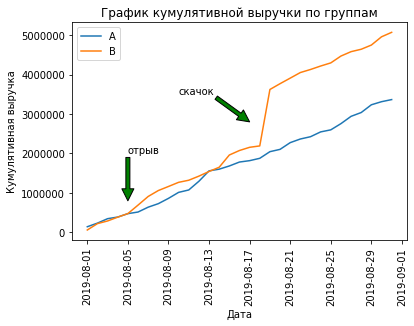

In [19]:
# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.xticks(rotation=90)
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend() 
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 
plt.show()

По построенному графику видим, что кумулятивная выручка в группе B превосходит таковую в группе A, но есть предположение, что в промежутке между 17 и 21 августа в группе В были совершены аномально дорогие покупки.

### график кумулятивного среднего чека по группам

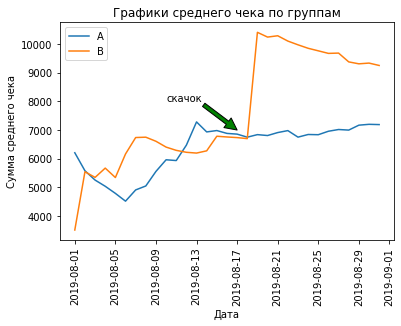

In [20]:
# Строим график среднего чека группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')

# Строим график среднего чека группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.xticks(rotation=90)
plt.title('Графики среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.annotate('скачок', xy=('2019-08-17', 7000), xytext=('2019-08-10', 8000),
            arrowprops=dict(facecolor='g'))
plt.legend() 
plt.show()

График среднего чека так же подтверждает гнипотезу о том, что в группе В были совершены аномально дорогие покупки. По данному графику сложно понять есть ли различия в среднем чеке по группам.

### график относительного изменения кумулятивного среднего чека группы B к группе A

In [21]:
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, on = 'date', suffixes = ['_a','_b'])
display(merged_cumulative_revenue.head())

,date,revenue_a,orders_a,revenue_b,orders_b
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


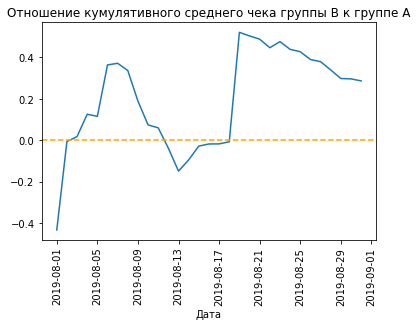

In [22]:
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/
         (merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a']) - 1)
plt.axhline(0, linestyle = '--', color = 'orange')
plt.xticks(rotation = 90)
plt.title('Отношение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.show()

Отношение кумулятивного среднего чека группы B к группе A постоянно колеблется и сложно сказать имеет ли какая - то группа преимущество.

### график кумулятивной конверсии по группам.

In [23]:
display(visitors_aggregated.head())

# Добавляем столбец с конверсией посетителей в покупателей
cumulative_data['conversion'] = cumulative_data['buyers']/cumulative_data['visitors']
display(cumulative_data.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845


,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.026426
1,2019-08-01,B,17,17,59758,713,0.023843
2,2019-08-02,A,42,36,234381,1338,0.026906
3,2019-08-02,B,40,39,221801,1294,0.030139
4,2019-08-03,A,66,60,346854,1845,0.032520


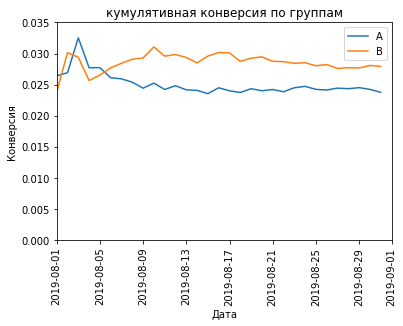

In [24]:
# График кумулятивной конверсии по группам.
plt.plot(cumulative_data.query('group == "A"')['date'], cumulative_data.query('group == "A"')['conversion'], label = 'A')
plt.plot(cumulative_data.query('group == "B"')['date'], cumulative_data.query('group == "B"')['conversion'], label = 'B')
plt.xticks(rotation = 90)
plt.legend()
plt.title('кумулятивная конверсия по группам')
plt.axis(["2019-08-01", '2019-09-01', 0, 0.035]) 
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

По графику кумулятивной конверсии по группам можно сделать вывод, что в группе В конверсия стабильно выше, чем в группе А.  

### график относительного изменения кумулятивной конверсии группы B к группе A

In [25]:
merged_сumulative_сonversions = cumulative_data.query('group == "A"')[['date','conversion']].merge(cumulative_data.query('group == "B"')[['date','conversion']], on = 'date', suffixes = ['_a','_b'])
display(merged_сumulative_сonversions.head())

,date,conversion_a,conversion_b
0,2019-08-01,0.026426,0.023843
1,2019-08-02,0.026906,0.030139
2,2019-08-03,0.032520,0.029395
3,2019-08-04,0.027713,0.025651
4,2019-08-05,0.027728,0.026524


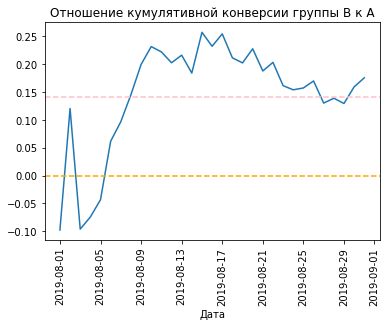

In [26]:
plt.plot(merged_сumulative_сonversions['date'], merged_сumulative_сonversions['conversion_b']/merged_сumulative_сonversions['conversion_a'] - 1)
plt.xticks(rotation = 90)
plt.title('Отношение кумулятивной конверсии группы B к A')
plt.axhline(0, linestyle = '--', color = 'orange')
plt.axhline(0.14, linestyle = '--', color = 'pink')
plt.xlabel('Дата')
plt.show()

В начале теста соотношение конверсии сильно колеблется, после этого начался рост. В середине теста соотношение конверсии пошло на убыль, но по прежнему конверсия в группе В оставалась выше, чем группе А, сейчас виден рост. В целом можно предположить, что конверсия в группе В лучше, чем в группе А . Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину. 

### точечный график количества заказов по пользователям

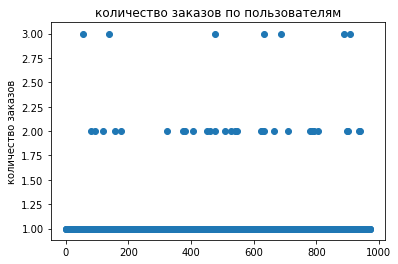

,visitor_id,transaction_id
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


In [27]:

orders_by_users = orders.groupby('visitor_id', as_index = False).agg({'transaction_id':'nunique'})

x_values = pd.Series(range(0, len(orders_by_users['visitor_id'])))
plt.scatter(x_values, orders_by_users['transaction_id'])
plt.title('количество заказов по пользователям')
plt.ylabel('количество заказов')
plt.show()

display(orders_by_users.sort_values(by = 'transaction_id', ascending = False).head())

Присутствуют пользователей с 2-3 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.



### 95-й и 99-й перцентили количества заказов на пользователя

In [28]:
print(np.percentile(orders_by_users['transaction_id'],[95, 99]))

[1. 2.]


Видим, что свыше двух заказов имеет только один процент пользователей, поэтому пользователей с количеством заказов больше двух можно исключить. 

### точечный график стоимостей заказов

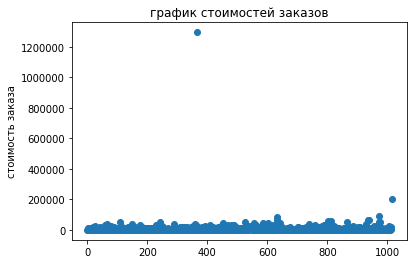

In [29]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('стоимость заказа')
plt.title('график стоимостей заказов')
plt.show()

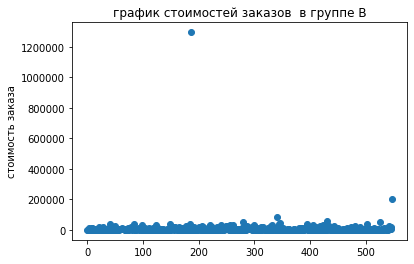

In [30]:
x_values = pd.Series(range(0, len(orders[orders['group'] == 'B']['revenue'])))
plt.scatter(x_values, orders[orders['group'] == 'B']['revenue'])
plt.ylabel('стоимость заказа')
plt.title('график стоимостей заказов  в группе В')
plt.show()

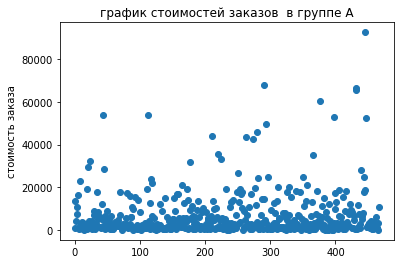

In [31]:
x_values = pd.Series(range(0, len(orders[orders['group'] == 'A']['revenue'])))
plt.scatter(x_values, orders[orders['group'] == 'A']['revenue'])
plt.ylabel('стоимость заказа')
plt.title('график стоимостей заказов  в группе А')
plt.show()

Построив точечный график стоимостей заказов видим, что действительно, в группе В были совершены аномально дорогие покупки, повлиявшие на средний чек и выручку в группе.

### 95-й и 99-й перцентили стоимости заказов

In [32]:
print(np.percentile(orders['revenue'], [95,99]))

[26785. 53904.]


Исходя из значений 95-й и 99-й перцентили, можно предположить, что стоимость покупок свыше 30000  аномальная и эти покупки стоит убрать из теста.

### подсчет статистической значимости различий в конверсии между группами по «сырым» данным

In [33]:
#display(visitors.head())

In [34]:
# создаем таблицу с количеством посетителей в определенную дату в группе А

visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

# количество посетителей до выбранной даты в группе А .
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}),axis=1)

visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}),axis=1)

visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

display(visitors_a_cummulative.head(), visitors_b_cummulative.head(), visitors_a_daily.head(),visitors_b_daily.head())

,date,visitors_cummulative_a
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


,date,visitors_cummulative_b
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


,date,visitors_per_date_a
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


,date,visitors_per_date_b
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [35]:
# Количество заказов и сумма в группе А по датам
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'}))

orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

# Кумулятивное количество заказов и сумма в группе А на определенную дату
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ), axis=1).sort_values(by=['date'])

orders_a_cummulative.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'}))

orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ), axis=1).sort_values(by=['date'])

orders_b_cummulative.columns = ['date','orders_cummulative_b','revenue_cummulative_b']

#display(orders_a_daily.head(),orders_a_cummulative.head(), orders_b_daily.head(),orders_b_cummulative.head() )

In [36]:
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5)) 

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [37]:
# Таблицы с количеством заказов для каждого пользователя.
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_b.columns = ['user_id', 'orders'] 

Формируем нулевую и альтернативную гипотезу для теста:
- Н0 - статистически значимых различий в конверсии между группами нет.
- Н1 - различие в конверсии групп А и В статистически значимо.

In [38]:
# Создаем объекты Series с количеством заказов каждого пользователя групп А И В

sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(
           data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])),
            name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(
           data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])),
            name='orders')], axis=0)

#print(sample_a.sort_values(ascending = False))

print("{0:.3f}".format(st.mannwhitneyu(sample_a, sample_b, alternative = 'two-sided')[1]))

print("{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

0.011
0.160


Вывод: По «сырым» данным имеются различия в конверсии групп A и B.
Первое число — p-value = 0.011, это меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный выигрыш группы B равен 16% .

### подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Формируем нулевую и альтернативную гипотезу для теста:

- Н0 - средний чек в группе А не отличается от такового в группе В.
- Н1 - различие между средним чеком групп А и В статистически значимо.

In [39]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.829
0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Но средний чек группы B значительно выше среднего чека группы A, что может быть связано с аномально дорогими покуками в группе В.

### подсчет статистической значимости различий в конверсии между группами по «очищенным» данным

In [40]:
users_with_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > 2]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['user_id']],axis=0)

users_with_expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values())

print(abnormal_users.head(5))
print('Количество анамальных пользователей:', abnormal_users.shape) 

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
dtype: int64
Количество анамальных пользователей: (49,)


Формируем нулевую и альтернативную гипотезу для теста:

- Н0 - статистически значимых различий в конверсии между группами нет.
- Н1 - различие в конверсии групп А и В статистически значимо.

In [41]:
sample_a_filtered = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))]['orders'],
                        pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])),
                        name='orders')],axis=0)


sample_b_filtered = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])),name='orders')],axis=0)

print('{0:.3f}'.format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered, alternative = 'two-sided')[1]))
print('{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

0.010
0.187


Нулевая гипотеза не подтверждается, рассчеты по очищенным данным, показывают, что разница по конверсии увеличилась ещё больше. p-value = 0.010. Относительный выигрыш группы B равен 18.7%.

### подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Формируем нулевую и альтернативную гипотезу для теста:

- Н0 - средний чек в группе А не отличается от такового в группе В.
- Н1 - различие между средним чеком групп А и В статистически значимо.

In [42]:
a_revenue_filtered = orders.query('group == "A" and visitor_id not in @abnormal_users')['revenue']
b_revenue_filtered = orders.query('group == "B" and visitor_id not in @abnormal_users')['revenue']
#display(a_revenue_filtered.head())
print('p-value:',round(st.mannwhitneyu(a_revenue_filtered, b_revenue_filtered, alternative = 'two-sided')[1], 3))
print(round((b_revenue_filtered.mean()/a_revenue_filtered.mean() - 1), 3))

p-value: 0.741
-0.027


Значение p-value немного изменилось, но по прежнему мы не можем отвергать нулевую гтпотезу. После удаления аномальных значений практически пропала разница между соотношением среднего чека группы А и группы В. 

### решение по результатам теста

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Продолжать смысла нет, потому как видно, что конверсия группы В стабильно выше, чем в группе А, при практически одинаковом среднем чеке по группам.

### Общий вывод:
В данном исследовании были реализованы следующие шаги:
- Предобрабртка данных:
 -  заменены типы данных в таблицах
 -  исправлены названия столбцов
 -  удалены пользователи, одновременно входящие как в группу А так и в группу В, их количество - 58 человек
 
- Приоритизация гипотез: 
 - При проверке приоритета гипотез без учета количества пользователей, которых эта гипотеза затронет наиболее перспективными оказались гипотезы 8, 0 и 7.
 - При проверке приоритета гипотез методом RICE, наиболее перспективны гипотезы 7, 2 и 0. Исходя из результатов обеих проверок можно предположить, что стоит сосредоточиться на гипотезах 7 и 0. Гипотеза №0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей. Гипотеза №7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
 
- Анализ A/B-теста:
   - график кумулятивной выручки по группам показывает, что кумулятивная выручка в группе B превосходит таковую в группе A, но есть предположение, что в промежутке между 17 и 21 августа в группе В были совершены аномально дорогие покупки.
   - график кумулятивного среднего чека так же подтверждает гнипотезу о том, что в группе В были совершены аномально дорогие покупки. По данному графику сложно понять есть ли различия в среднем чеке по группам.
   - построен график относительного изменения кумулятивного среднего чека группы B к группе A, показатели постоянно колеблятся и сложно сказать имеет ли какая - то группа преимущество.
   - построен график кумулятивной конверсии по группам, по нему можно сделать вывод, что в группе В конверсия стабильно выше, чем в группе А.
   - построен график относительного изменения кумулятивной конверсии группы B к группе A, в целом по нему можно предположить, что конверсия в группе В лучше, чем в группе А, но сперва стоит проанализировать аномалии, возможно, они изменят картину.
   - построив точечный график стоимостей заказов видим, что действительно, в группе В были совершены аномально дорогие покупки, повлиявшие на средний чек и выручку в группе.
   - посчитан 95-й и 99-й перцентили количества заказов на пользователя и стоимости заказов. Из полученных данных делаем вывод, что количество заказов больше 2-х и сумма заказа свыше 30000 явлются аномальными, этих пользователей можно исключить.
   - произведен подсчет статистической значимости различий в конверсии между группами по «сырым» данным. Между группами имеются  статистически значимые различия в конверсии . Относительный выигрыш группы B равен 16%.
   - произведен подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным, тест отличий не показал. Но соотношение средннго чека группы B к чеку группы A, показывает, что в группе В средний чек больше, это может быть связано с аномально дорогими покуками в группе В. 
   - подсчет статистической значимости различий в конверсии между группами по «очищенным» данным показал, что разница по конверсии увеличилась ещё больше. Относительный выигрыш группы B равен 18.7%.
   - подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным показал, что после удаления аномальных значений практически пропала разница между соотношением среднего чека группы А и группы В.
   
Исходя из всешо вышеперечисленного делаем вывод, что тест следует остановить и признать его успешным. Продолжать смысла нет, потому как видно, что конверсия группы В стабильно выше, чем в группе А, при практически одинаковом среднем чеке по группам.